In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

%matplotlib inline


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [2]:
hist_path = '/home/steve/documents/flatIron/fIProject/DF/current_hist.csv'
msft_hist = pd.read_csv(hist_path)
msft_hist.drop(columns=['ticker', 'date'],axis=0, errors='ignore', inplace=True,)
# msft_hist.set_index('date')
msft_array = msft_hist.to_numpy()
msft_len = len(msft_array)

In [3]:
msft_close = msft_hist['close']

<AxesSubplot:>

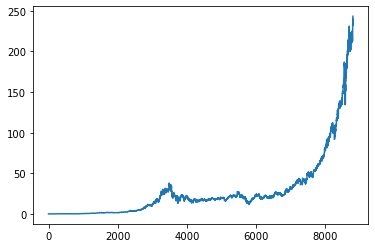

In [4]:
msft_close.plot()

In [5]:
msft_close.describe()

count    8796.000000
mean       28.473468
std        40.695936
min         0.057472
25%         2.420872
50%        18.634003
75%        26.786641
max       243.250000
Name: close, dtype: float64

In [6]:
msft_len = len(msft_close)
msft_recent = np.array(msft_close.iloc[msft_len-100:])

In [7]:
# natural -> np.array
# returns a stacked array of randomly generated inputs/outputs for sine function
def generate_samples(n=100):
    # generate random inputs -5 <= x <= 5
    X1 = (np.random.rand(n))*(msft_len-(msft_len-100))
    # generate random outputs (sine)
    y1 = msft_recent
    
    # stack arrays
    X1 = X1.reshape(n, 1)
    y1 = y1.reshape(n, 1)
    return np.hstack((X1,y1))

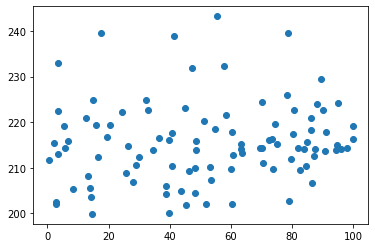

In [8]:
data = generate_samples()

plt.scatter(data[:, 0], data[:, 1])
plt.show()

# Full GAN Model

9999 0.7200000286102295 0.0


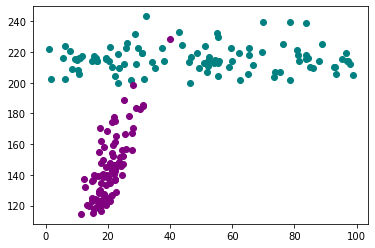

In [9]:
# define standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu',kernel_initializer='he_uniform',input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
# define standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu',kernel_initializer='he_uniform',input_dim=latent_dim))
    model.add(Dense(n_outputs,activation='linear'))
    return model
# define combined generator and discriminator model for updating generator
def define_gan(generator, discriminator):
    # make weights in discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy',optimizer='adam')
    return model
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-5,5]
    X1 = rand(n)*(msft_len-(msft_len-n))
    
    X2 = np.array(msft_close.iloc[msft_len-n:])
    # stack arrays
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    X = hstack((X1,X2))
    # generate class labels
    y = ones((n,1))
    return X, y
# generate points in latent space as input for generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim*n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n,1))
    return X, y
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    plt.scatter(x_real[:,0], x_real[:,1], color='teal')
    plt.scatter(x_fake[:,0], x_fake[:,1], color='purple')
    plt.show()
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch for updating the discriminator
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake samples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if(i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, n_eval=10000)